In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms, utils

import ImageDataset

from skimage import io, transform
from skimage.color import rgb2yuv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import os
import importlib

import Logger
import ContextEncoders
%matplotlib inline

/home/dmitrii/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
image_size = 128
train_dataset = ImageDataset.ImageDataset(["../data/mscoco_test2017/"], im_size=image_size)
data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [2]:
netG = ContextEncoders.NetG().cuda()
netD = ContextEncoders.NetLocalD().cuda()
criterionAdv = nn.BCELoss().cuda()
criterionMSE = nn.MSELoss().cuda()
optimizerG = optim.Adam(netG.parameters(), lr=0.0002,)# betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002,)# betas=(0.5, 0.999))
adv_loss_weight = 0.001

In [6]:
import utils
utils.get_n_params(netG)

52642368

In [4]:
netG.load_state_dict(torch.load('model/G_checkpoint'))
netD.load_state_dict(torch.load('model/D_checkpoint'))

In [28]:
logger = Logger.Logger('./logs_retrained')
for epoch in range(11):
    for i, data in enumerate(data_loader):
        input_batch = data['distorted'].cuda()
        batch_size = input_batch.size(0)
        real_centers_batch = Variable(data['gt'][:,:,int(image_size//8*3):-int(image_size//8*3),int(image_size//8*3):-int(image_size//8*3)].cuda())

        netD.zero_grad()
        real_labels = Variable(torch.ones(batch_size).cuda())
        D_real_output = netD(real_centers_batch)
        errD_real = criterionAdv(D_real_output, real_labels)
        errD_real.backward()
        
        G_output = netG(Variable(input_batch))
        fake_labels = Variable(torch.zeros(batch_size).cuda())
        D_fake_output = netD(G_output.detach())
        errD_fake = criterionAdv(D_fake_output, fake_labels)
        errD_fake.backward()
        errD = errD_fake + errD_real
        optimizerD.step()
        
        # Actually it would probably be better to split D and G training.
        netG.zero_grad()
        D_fake_output = netD(G_output)
        errG_D = criterionAdv(D_fake_output, real_labels)
        errG_L2 = criterionMSE(G_output, real_centers_batch)
        errG = adv_loss_weight*errG_D + errG_L2
        errG.backward()
        optimizerG.step()
        
        if (i%4000 == 0):
            print ("D loss: {:.4f}, G_L2 loss: {:.4f}, G_D loss: {:.4f}".format(errD.data[0], errG_L2.data[0], errG_D.data[0]))
        
    #============ TensorBoard logging ============#
    # (1) Log the scalar values
#     info = {
#         'errD_real': errD_real.data[0],
#         'errD_fake': errD_fake.data[0],
#         'errG_D': errG_D.data[0],
#         'errG_L2': errG_L2.data[0]
#     }
#     for tag, value in info.items():
#         logger.scalar_summary(tag, value, epoch+1)

#     if epoch%3==0:
#         # (2) Log examples of filled output images
#         ind = np.random.randint(0, batch_size)            
#         sample_to_log = input_batch[ind]
#         sample_to_log[:,image_size//8*3:-image_size//8*3,image_size//8*3:-image_size//8*3] = G_output[ind].data
#         info = {
#             'images'+str(epoch): [sample_to_log.cpu().numpy()]
#         }
#         for tag, images in info.items():
#             logger.image_summary(tag, images, epoch+1)

    #torch.save(netD.state_dict(), 'model/D_checkpoint_retrain')
    #torch.save(netG.state_dict(), 'model/G_checkpoint_retrain')

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


D loss: 0.0109, G_L2 loss: 0.0851, G_D loss: 5.4252


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


D loss: 0.0277, G_L2 loss: 0.0786, G_D loss: 5.4420
D loss: 0.0062, G_L2 loss: 0.0833, G_D loss: 6.5179


KeyboardInterrupt: 

In [33]:
def fill_hole(netG, sample):
    input_img = sample['distorted'].cuda()
    im_size = input_img.size(2)
    output = netG(Variable(input_img.unsqueeze(0)))
    input_img[:,im_size//8*3:-im_size//8*3,im_size//8*3:-im_size//8*3] = output.data[0]
    return (input_img.cpu() + 1) / 2

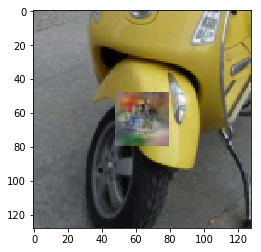

In [34]:
plt.imshow(transforms.ToPILImage()(fill_hole(netG, train_dataset.__getitem__(6))))